In [1]:
#@title # Setting up the environment { vertical-output: true, display-mode: "form" }

###################
#####  SETUP  #####
###################

print("Mounting google drive.. ")
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# setting the project path
PROJECT_PATH = "/content/drive/MyDrive/TWM/" #@param {type:"string"}

print("Navigating to the project folder.. ")
import os
os.chdir(PROJECT_PATH)
print("Found the following files:", os.listdir())

DEPENDENCIES_PATH = "Dependencies" #@param {type:"string"}
DEPENDENCIES_PATH = os.path.join(PROJECT_PATH, DEPENDENCIES_PATH)
# !pip install --prefix=$DEPENDENCIES_PATH -U matplotlib -q
# !pip install --prefix=$DEPENDENCIES_PATH colorama Unidecode contextualSpellCheck -q

import sys
sys.path.insert(0, os.path.join(DEPENDENCIES_PATH, "lib/python3.7/site-packages"))

# importing dependencies
import re
import random
import string
from collections import Counter

import spacy
import contextualSpellCheck

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from colorama import Fore, Back, Style
from unidecode import unidecode

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.display import display

import Utils.helperFunctions as helperFunctions
import Utils.dialogue_utils as dialogue_utils

###################
##### CONFIGS #####
###################

print("Navigating to the data directory..")
DATA_DIRECTORY = "DataEngineering/MergedDataset" #@param {type:"string"}
os.chdir(DATA_DIRECTORY)
print("Found the following files:", os.listdir())

MERGED_DATASET_FILENAME = "merged_dataset.csv" # @param {type:"string"}

SEED = 511 #@param {type:"integer"}
print("Setting the project seed.. ")
def seed_everything(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
seed_everything()

MATPLOTLIB_STYLE = "seaborn" #@param {type:"string"}
plt.style.use(MATPLOTLIB_STYLE)

print("Done")

Mounting google drive.. 
Mounted at /content/drive
Navigating to the project folder.. 
Found the following files: ['DataEngineering', 'FineTuning', 'TrainingFromScratch', 'Utils', 'Testing Interface.ipynb', 'hierarchy.txt', 'Dependencies']
Navigating to the data directory..
Found the following files: ['merged_dataset.csv']
Setting the project seed.. 
Done


# Inspecting The Distributions In The Merged Dataset

In [2]:
# @title ## Loading The Merged Dataset

# The index of the dataframe is not from 1 to df.shape[0]
# each index refers to the index of the dialogue in the original csv file 
# that the dialogue came from
merged_df = pd.read_csv(MERGED_DATASET_FILENAME, index_col=0)

display(merged_df)
display(merged_df.info())

,dialogue,dataset,topic,subtopic1,subtopic2
4,"#Person1#: Watsup, ladies! Y'll looking'fine t...",DialogSum,Arts & Entertainment,NaN,NaN
12,#Person1#: Did Bean send these dirty jokes to ...,DialogSum,Arts & Entertainment,Humor,NaN
14,#Person1#: What kind of music do you like list...,DialogSum,Arts & Entertainment,Music & Audio,NaN
24,#Person1#: Out of every movie that you've seen...,DialogSum,Arts & Entertainment,Movies,NaN
25,#Person1#: What's all the security check about...,DialogSum,Arts & Entertainment,NaN,NaN
...,...,...,...,...,...
9845,#Person1#:Can I get a car for 4 on Friday nigh...,MSR-E2E,Autos & Vehicles,NaN,NaN
9911,#Person1#:April 16th at 4pm\n#Person2#:How man...,MSR-E2E,Autos & Vehicles,NaN,NaN
9948,#Person1#:Please send a fuel efficient vehicle...,MSR-E2E,Autos & Vehicles,NaN,NaN
10013,#Person1#:I need a ride to Hamm's Tires on S C...,MSR-E2E,Autos & Vehicles,Vehicle Parts & Services,Vehicle Parts & A


<class 'pandas.core.frame.DataFrame'>
Int64Index: 123362 entries, 4 to 10044
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   dialogue   123362 non-null  object
 1   dataset    123362 non-null  object
 2   topic      123362 non-null  object
 3   subtopic1  81833 non-null   object
 4   subtopic2  13142 non-null   object
dtypes: object(5)
memory usage: 5.6+ MB


None

In [4]:
# @title ## Merged Dataset Statistics
def pprint_df(df, columns=None):
    formatter = lambda v: int(v) if v < 1e3 else \
                          f"{v//1e3:,.0f}K" if v < 1e6 else \
                          f"{v/1e6:,.2f}M"
    df = df.copy()
    columns = columns if columns else df.columns
    for col in columns:
        df[col] = df[col].apply(formatter)
    display(df)

dataset_names = merged_df['dataset'].unique()
topic_names = merged_df['topic'].unique()

merged_stats_df = merged_df.groupby('topic').apply(dialogue_utils.get_stats)
merged_stats_df = merged_stats_df.apply(pd.Series).astype(int)
merged_stats_df = merged_stats_df.loc[topic_names]
merged_stats_df.loc['Total'] = dialogue_utils.get_stats(merged_df)

pprint_df(merged_stats_df)

,# dialogues,# utterances,avg # turns in a dialogue,avg # words in a turn
topic,,,,
Arts & Entertainment,67K,934K,13,9
Food & Drink,21K,349K,15,9
Travel,20K,387K,18,10
Sports,6K,82K,13,8
People & Society,3K,27K,7,11
Autos & Vehicles,3K,63K,19,9
Total,123K,1.84M,14,9


In [5]:
# @title ## Number of Topics in Each Dataset

DATASET_NAMES = merged_df['dataset'].unique()
TOPIC_NAMES = merged_df['topic'].unique()

def get_counts_df(df):
    counts_df = df.groupby('dataset')
    counts_df = counts_df.apply(lambda df: df['topic'].value_counts().to_frame().T)
    counts_df = counts_df.droplevel(1).fillna(0)
    counts_df = counts_df.loc[DATASET_NAMES][TOPIC_NAMES] # reorder
    counts_df['Total'] = counts_df.sum(axis=1)
    counts_df.loc['Total'] = counts_df.sum(axis=0)
    return counts_df

counts_df = get_counts_df(merged_df)
pprint_df(counts_df)

,Arts & Entertainment,Food & Drink,Travel,Sports,People & Society,Autos & Vehicles,Total
dataset,,,,,,,
DialogSum,1K,741,442,289,288,127,3K
DailyDialog,1K,619,319,205,226,103,2K
Cornell Movie--Dialogs Corpus,16K,385,106,274,1K,171,18K
Commonsense-Dialogues,1K,256,28,162,127,91,2K
EmpatheticDialogues,2K,475,144,354,501,249,4K
MultiWOZ 2.2,184,2K,3K,3,58,59,6K
Taskmaster-2,4K,3K,3K,2K,26,0,14K
MetaLWOZ,5K,2K,1K,1K,536,123,10K
Taskmaster-1,2K,6K,1K,7,4,1K,11K


array([<AxesSubplot:title={'center':'Contribution Of Each Dataset To The Merged Dataset'}, xlabel='Number of Dialogues', ylabel='dataset'>,
       <AxesSubplot:title={'center':'Distribution Of Topics In The Merged Dataset'}, xlabel='Number of Dialogues'>],
      dtype=object)

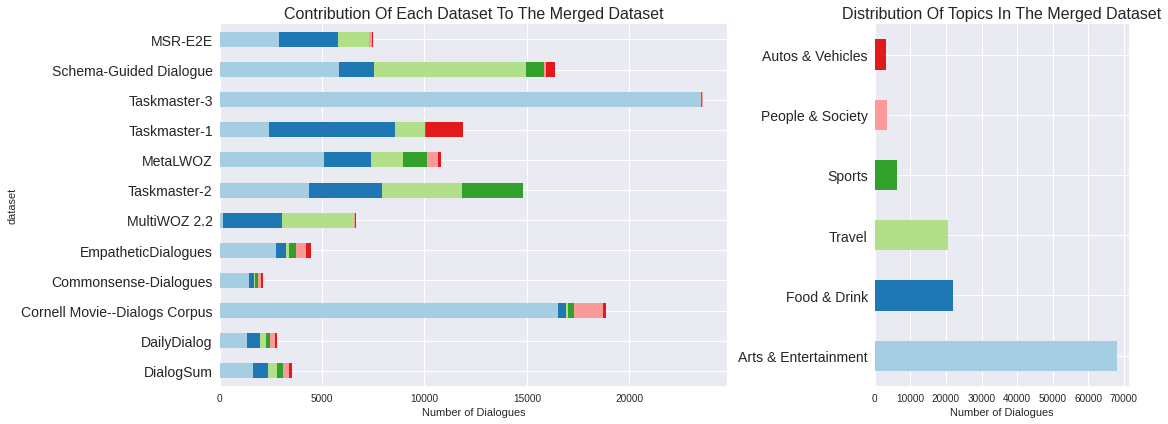

In [6]:
# @title ## Merged Dataset Distributions

colors = sns.color_palette("rocket")
colors = sns.color_palette("Paired")

def plot_df_distributions(df, title, fig=None, axes=None, add_labels=True):
    if fig==None:
        fig, axes = plt.subplots(
            ncols=2, 
            figsize=(16, 6), 
            gridspec_kw={'width_ratios': [2, 1]}
        )

    counts_df = get_counts_df(df)
    contribution_df = counts_df.drop(columns=['Total'], index='Total')
    contribution_df.plot(
        use_index=True, 
        kind='barh', 
        stacked=True, 
        ax=axes[0], 
        color=colors,
        legend=False,
    )


    counts_df.loc['Total'][:-1].plot(
        kind='barh', 
        color=colors[:len(TOPIC_NAMES)], 
        ax=axes[1]
    )

    axes[0].set_title(title)
    axes[1].set_title(title)

    if add_labels:
        axes[0].set_title(
            f"Contribution Of Each Dataset To The {title}", 
            fontsize=16)

        axes[1].set_title(
            f'Distribution Of Topics In The {title}', 
            fontsize=16
        )
        axes[0].set_yticks(range(len(DATASET_NAMES)))
        axes[0].set_yticklabels(DATASET_NAMES, fontsize=14)
        axes[1].set_yticks(range(len(TOPIC_NAMES)))
        axes[1].set_yticklabels(TOPIC_NAMES, fontsize=14)

        axes[0].set_xlabel('Number of Dialogues')
        axes[1].set_xlabel('Number of Dialogues')
    else:
        axes[0].get_yaxis().set_ticks([])
        axes[1].get_yaxis().set_ticks([])

    plt.tight_layout()
    # plt.show()
    return axes


plot_df_distributions(merged_df, "Merged Dataset")

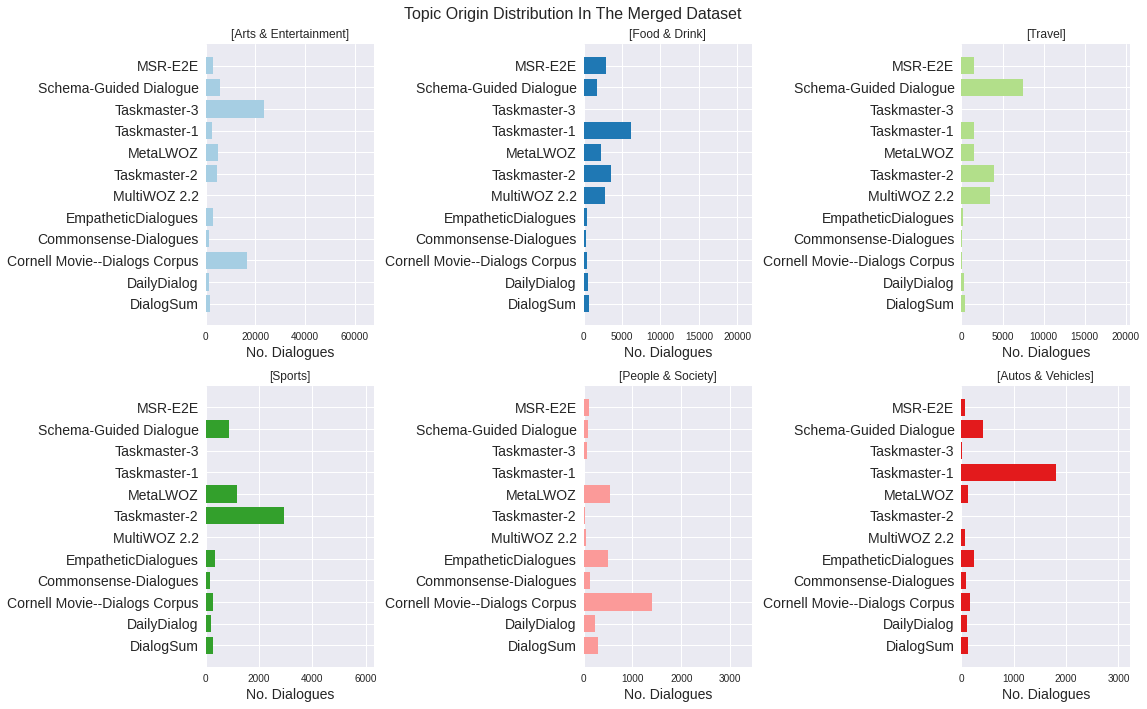

In [7]:
# @title ## Topic Origin Distributions
n_topics = len(topic_names)

grouped_df = merged_df.groupby(by=['topic', 'dataset']).apply(len)

# max_count = grouped_df.max()
# max_count = merged_df.shape[0]

ncols = 3
nrows = int(np.ceil(n_topics/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,5*nrows))
for ax in axes.flat:
    ax.axis('off')

for i, (ax, topic) in enumerate(zip(axes.flat, topic_names)):
    ax.axis('on')
    topic_df = merged_df[merged_df['topic']==topic]
    counts = [topic_df[topic_df['dataset']==d].shape[0] for d in dataset_names]
    max_count = sum(counts)

    ax.barh(dataset_names, counts, color=colors[i])
    ax.set_yticks(range(len(dataset_names)))
    ax.set_yticklabels(dataset_names, fontsize=14)

    ax.set_title(f"[{topic}]", fontsize=12)#, y=-0.2)
    ax.set_xlabel("No. Dialogues", fontsize=14)
    ax.set_xlim(0, max_count)

fig.suptitle("Topic Origin Distribution In The Merged Dataset", fontsize=16)#, y=1.05)

plt.tight_layout()
plt.show()

# Preprocessing

## Transliteration: handling non-ASCII characters



In [8]:
#@title ###Counting Non-ASCII characters

# define a normal charset
# normal charset contains digits, letters, punctuation, etc..
normal_charset = set(string.printable)

# get the unique characters from the given dataframe
get_charset = lambda df: set(''.join(df['dialogue']))

# get the non normal charset 
# emojis are not considered of the normal charset
get_non_ascii_charset = lambda charset: charset-normal_charset

# printing the number of characters in every dataset
charsets = merged_df.groupby(['dataset']).apply(get_charset)

non_ascii_charsets = charsets.apply(get_non_ascii_charset)
frames = [
    charsets.apply(len).to_frame('# chars'),
    non_ascii_charsets.apply(len).to_frame("# non-ascii chars"),
    non_ascii_charsets.apply(lambda s: ''.join(s)).to_frame("non-ascii chars")
]

charsets_stats_df = pd.concat(frames, axis=1)
charsets_stats_df

,# chars,# non-ascii chars,non-ascii chars
dataset,,,
Commonsense-Dialogues,78,1,’
Cornell Movie--Dialogs Corpus,123,30,Èéï¹èàêÇä£áú³ñí óü²«ç­
DailyDialog,95,11,¥–‘—£”°’“、。
DialogSum,86,0,
EmpatheticDialogues,98,3,’😢
MSR-E2E,154,62,Žé¶¿ª¯½Ÿð╜┬¡àÆ║Γ┼Ê±â•⌐¨ºÇä“Â¦£¼œ©鈥úŒñ Û├€í‰óÃ...
MetaLWOZ,98,1,’
MultiWOZ 2.2,87,0,
Schema-Guided Dialogue,90,0,


In [9]:
#@title ###Checking the most frequent non-ascii characters
#@markdown we can see that the most frequent characters have ascii replacements
all_non_ascii = set(''.join(charsets_stats_df['non-ascii chars']))

# checking the frequence of every non normal char
char_counts = Counter(''.join(merged_df['dialogue']))

non_ascii_counts = {c:char_counts[c] for c in all_non_ascii}
non_ascii_counts = sorted(non_ascii_counts.items(), key=lambda x: x[1], reverse=True)

# labels, counts = list(zip(*non_ascii_counts[:15]))
# plt.barh(labels, counts)
# plt.show()
non_ascii_counts[:15]

[('’', 37393),
 ('\xa0', 3098),
 ('”', 487),
 ('\x97', 438),
 ('“', 407),
 ('\x92', 383),
 ('\u200b', 361),
 ('é', 275),
 ('´', 243),
 ('è', 210),
 ('–', 204),
 ('\x96', 118),
 ('ñ', 102),
 ('‘', 84),
 ('í', 52)]

In [10]:
#@title ###Printing sample sentences that contain non-ascii characters
# check sentences with non normal chars
def color_non_ascii(utterance, non_ascii_charset):
    for ch in non_ascii_charset:
        utterance = utterance.replace(
            ch, 
            Style.RESET_ALL + Fore.RED + ch + Style.RESET_ALL + Back.LIGHTBLACK_EX
        )
    return Back.LIGHTBLACK_EX + utterance

# setting the width of each sentence
# some sentences will look shorter though, that's because some of the
# non-normal characters are invisible
def get_non_ascii_samples(dialogues, width=60, all_non_ascii=all_non_ascii):
    samples = set()
    for i, ch in enumerate(all_non_ascii):
        is_char_in = lambda s: ch in s
        mask = dialogues.apply(is_char_in)
        sample_dialogues = dialogues[mask]
        n = len(sample_dialogues)
        dialogue = sample_dialogues.iloc[i%n]
        
        dialogue = ' '.join(d[10:] for d in dialogue.split("\n"))
        index = dialogue.find(ch)
        utterance = (dialogue[max(index-width, 0):index].rjust(width)
                    +dialogue[index:index+width].ljust(width))
        
        # print(color_non_ascii(utterance, all_non_ascii))
        samples.add((utterance, color_non_ascii(utterance, all_non_ascii)))
    return samples

samples = get_non_ascii_samples(merged_df['dialogue'])
print("\n".join([t[1] for t in samples]))

ecaf breva ... .  You and your fancy Italian names .  Isn't “ frappuccino ” Italian , too ? ... and heat me up a panini 
the Hornets with a 20-point margin. Who's the coach of the Cádiz? Dave joerger coaches the Sacramento Kings. Who is the 
 these options for you? Is Pakpao Thai very expensive? Ã¢â‚¬Å½Price range is $30 and under for Pakpao Thai. Would you li
i help you? Hi, can you play something by Wale, please? WALL∙E’s “Day At Work”. No, can you play something by Wale? Plea
 for you. I would like a medium thin crust pizza with jalapeños and mushrooms. I'm sorry, we are out of mushrooms can yo
ality. So you said at the time. Speaking of which, your protg's first rare -- a trifle emotional -- She's half Romulan
ting in? I will be in Santa Cruz. Okay, I found five places.​ Zoccoli's Delicatessen established Italian deli featuring 
ould you like to select another date or restaurant? 3Å’Å½1â€œÃº Sorry, there are no tables available for the date/time s
Farallon - Rating: 4 out of 5. 2

In [11]:
#@title ###The 'unidecode' library
#@markdown It's easy to see that most of these characters have a replacement or can be removed without affecting the sentence. After some googling, I found a package called [unidecode](https://pypi.org/project/Unidecode/) that can map/transliterate non-ascii characters to ascii characters.

#@markdown Here's the Non-ASCII ---> ASCII pairs generated from the 'unidecode' library.
#@markdown 
#@markdown Note: if the character is invisible, it is represented with it's ASCII code

non_ascii_to_ascii = {ch:unidecode(ch) for ch in all_non_ascii}

format_value = lambda t: Style.RESET_ALL + Fore.RED + repr(rf"{t[0]}")[1:-1] + Style.RESET_ALL + \
                         "-->" + \
                         Style.RESET_ALL + Fore.BLUE + repr(rf"{t[1]}")[1:-1] + Style.RESET_ALL 

# format_value = lambda t: rf"{t[0]}" + "-->" + rf"{t[1]}"

def pprint_dict(dictionary, ncols=9):
    mapper = list(dictionary.items())
    for i in range(0, len(mapper), ncols):
        row = mapper[i:i+ncols]
        row = [format_value(v) for v in row]
        row = [v.ljust(41) for v in row]
        print('   '.join(row))

pprint_dict(non_ascii_to_ascii)

ë-->e             È-->E             ¶-->P             ª-->a             ¯-->-             ”-->"             ¹-->1             ╜-->+             ß-->ss         
¡-->!             ¥-->Y=            ‧-->.             º-->o             ä-->a             “-->"             á-->a             ú-->u             ñ-->n          
Û-->U             ü-->u             ╖-->+             É-->E             Ö-->O             ギ-->gi            \x92-->           é-->e             ½--> 1/2       
\x81-->           \x82-->           \x97-->           è-->e             ║-->|             —-->--            ŕ-->r             \x8c-->           ć-->c          
メ-->me            ツ-->tsu           ¨-->"             ®-->(r)           。-->.             ś-->s             Â-->A             鈥-->Huo           \u200e-->      
♫-->              ‰-->%0            –-->-             Ã-->A             ā-->a             Ñ-->N             ™-->(tm)          \x93-->           ∙-->           
²-->2             Ì-->I             ネ-->

In [12]:
#@title ## A simple transliteration approach: use a character mapper

#@markdown Things to note:
#@markdown - The mapper needs to be adjusted.
#@markdown - Consecutive Non-ASCII characters are mostly gibberish, they should be discarded instead of being remapped.

#@markdown It did a great job overall, but the mapping for some characters need to be adjusted a little. The fastest way is to adjust the mapper manually.

# create a temp mapper
to_be_removed = '╖‰¤'# 'メネ鈥¥ツギ'
adjusted_mapper = {ch:'' for ch in to_be_removed}
adjusted_mapper['¢'] = 'c'
adjusted_mapper['„'] = '"'

# update the original mapper
non_ascii_to_ascii.update(adjusted_mapper)

def fix_non_ascii(text, mapper):
    """
        A simple function that replaces non-ascii characters using the given mapper.
    """
    for ch, replacement in mapper.items():
        text = text.replace(ch, replacement)
    return text

# print the samples before and after fixing
for _, sample in samples:
    print(Style.RESET_ALL, "Original :", sample)
    print(Style.RESET_ALL, "After fix:", fix_non_ascii(sample, non_ascii_to_ascii))
    print(Style.RESET_ALL, "----------")

 Original : ecaf breva ... .  You and your fancy Italian names .  Isn't “ frappuccino ” Italian , too ? ... and heat me up a panini 
 After fix: ecaf breva ... .  You and your fancy Italian names .  Isn't " frappuccino " Italian , too ? ... and heat me up a panini 
 ----------
 Original : the Hornets with a 20-point margin. Who's the coach of the Cádiz? Dave joerger coaches the Sacramento Kings. Who is the 
 After fix: the Hornets with a 20-point margin. Who's the coach of the Cadiz? Dave joerger coaches the Sacramento Kings. Who is the 
 ----------
 Original :  these options for you? Is Pakpao Thai very expensive? Ã¢â‚¬Å½Price range is $30 and under for Pakpao Thai. Would you li
 After fix:  these options for you? Is Pakpao Thai very expensive? Aca,!A 1/2 Price range is $30 and under for Pakpao Thai. Would you li
 ----------
 Original : i help you? Hi, can you play something by Wale, please? WALL∙E’s “Day At Work”. No, can you play something by Wale? Plea
 After fix: i help you? Hi, c

In [13]:
#@title ### A more sophisticated transliteration approach:

#@markdown - Remove consecutive Non-ASCII characters first
#@markdown - Then transliterate any remaining Non-ASCII characters using the modified mapper


#@markdown It looks good enough. It's not %100 perfect, but it's safe to move forward with this.



# the new values to be re-mapped
adjusted_mapper['ŕ'] = "'r"
adjusted_mapper['¥'] = "Y"
adjusted_mapper['¹'] = "'"

# update the original mapper
non_ascii_to_ascii.update(adjusted_mapper)

def transliterate_non_ascii(text, mapper):
    """
        A more sophisticated approach to transliterate non-ascii characters

        Here's the main idea:
            1. Find the longest sequence of non-ascii characters
            2. if the size of the sequence > 1, remove the sequence
               else, replace it using the given mapper
    """
    seq = ''
    to_be_removed = []
    for i, ch in enumerate(text):
        if ch in mapper:
            seq += ch
        else:
            # to be removed
            if (len(seq)>1):
                to_be_removed.append(seq)
                seq = ''

    # remove consecutive sequences first
    for seq in to_be_removed:
        text = text.replace(seq, '')
    
    # then replace single non ascii chars from the mapper
    text = fix_non_ascii(text, mapper)

    return text

# print the samples before and after fixing
for sample, c_sample in samples:
    print(Style.RESET_ALL + "Original :", c_sample)
    print(Style.RESET_ALL + "After Fix:", Back.LIGHTBLACK_EX + transliterate_non_ascii(sample, non_ascii_to_ascii))
    print(Style.RESET_ALL + "----------")

Original : ecaf breva ... .  You and your fancy Italian names .  Isn't “ frappuccino ” Italian , too ? ... and heat me up a panini 
After Fix: ecaf breva ... .  You and your fancy Italian names .  Isn't " frappuccino " Italian , too ? ... and heat me up a panini 
----------
Original : the Hornets with a 20-point margin. Who's the coach of the Cádiz? Dave joerger coaches the Sacramento Kings. Who is the 
After Fix: the Hornets with a 20-point margin. Who's the coach of the Cadiz? Dave joerger coaches the Sacramento Kings. Who is the 
----------
Original :  these options for you? Is Pakpao Thai very expensive? Ã¢â‚¬Å½Price range is $30 and under for Pakpao Thai. Would you li
After Fix:  these options for you? Is Pakpao Thai very expensive? Price range is $30 and under for Pakpao Thai. Would you li
----------
Original : i help you? Hi, can you play something by Wale, please? WALL∙E’s “Day At Work”. No, can you play something by Wale? Plea
After Fix: i help you? Hi, can you play something 

In [14]:
#@title ###Apply the transliteration on the dataset and count again
merged_df['dialogue'] = merged_df['dialogue'].apply(transliterate_non_ascii, args=(non_ascii_to_ascii,))

#@markdown Final table for mapping Non-ASCII to ASCII characters:
pprint_dict(non_ascii_to_ascii)

merged_df.groupby(['dataset']).apply(get_charset).apply(get_non_ascii_charset).apply(len).to_frame("# non-ascii")

ë-->e             È-->E             ¶-->P             ª-->a             ¯-->-             ”-->"             ¹-->'             ╜-->+             ß-->ss         
¡-->!             ¥-->Y             ‧-->.             º-->o             ä-->a             “-->"             á-->a             ú-->u             ñ-->n          
Û-->U             ü-->u             ╖-->              É-->E             Ö-->O             ギ-->gi            \x92-->           é-->e             ½--> 1/2       
\x81-->           \x82-->           \x97-->           è-->e             ║-->|             —-->--            ŕ-->'r            \x8c-->           ć-->c          
メ-->me            ツ-->tsu           ¨-->"             ®-->(r)           。-->.             ś-->s             Â-->A             鈥-->Huo           \u200e-->      
♫-->              ‰-->              –-->-             Ã-->A             ā-->a             Ñ-->N             ™-->(tm)          \x93-->           ∙-->           
²-->2             Ì-->I             ネ-->

,# non-ascii
dataset,
Commonsense-Dialogues,0
Cornell Movie--Dialogs Corpus,0
DailyDialog,0
DialogSum,0
EmpatheticDialogues,0
MSR-E2E,0
MetaLWOZ,0
MultiWOZ 2.2,0
Schema-Guided Dialogue,0


## Text Cleaning

After normalizing all characters to ASCII characters, there are still some characters/character sequences that need to be replaced/removed from the dataset. Most of these sequences were discovered by carefully inspecting the dialogues.

In [15]:
#@title Before Replacing:

# ther order matters, so I used a list of tuples instead of a dictionary
to_be_removed = [
    (r"\r\n",""),
    (r"\r",""),
    (r"\t",""),
    (r"__comma__", ","),
    (r'_comma_', ","),
    (r"_", ""),
]

all_data = ''.join(merged_df['dialogue'])

clean_df = merged_df.copy()

for pattern, replacement in to_be_removed:
    print(rf"Found '{all_data.count(pattern):<6}' occurrences of {repr(pattern)}")
    clean_df['dialogue'] = clean_df['dialogue'].apply(lambda s: s.replace(pattern, replacement))

Found '769   ' occurrences of '\\r\\n'
Found '10282 ' occurrences of '\\r'
Found '219   ' occurrences of '\\t'
Found '1     ' occurrences of '__comma__'
Found '7159  ' occurrences of '_comma_'
Found '14970 ' occurrences of '_'


In [16]:
#@title After Replacing:
all_data = ''.join(clean_df['dialogue'])
for pattern, replacement in to_be_removed:
    print(rf"Found '{all_data.count(pattern):<6}' occurrences of {repr(pattern)}")

Found '0     ' occurrences of '\\r\\n'
Found '0     ' occurrences of '\\r'
Found '0     ' occurrences of '\\t'
Found '0     ' occurrences of '__comma__'
Found '0     ' occurrences of '_comma_'
Found '0     ' occurrences of '_'


## Checking Spelling Errors & Correcting them

> Spelling errors are broadly classified as non-word errors (NWE) and real word errors (RWE). If the misspelt string is a valid word in the language, then it is called an RWE, else it is an NWE.
>
> -- [Monojit Choudhury et. al. (2007)](https://arxiv.org/abs/physics/0703198)


### Counting Misspelled Words

### [Context-Based Spell Correction](https://spacy.io/universe/project/contextualSpellCheck)


There's a package in Spacy that performs spell correction on non-word errors (NWE) or resolve OOVs (out-of-vocabulary) with something meaningful given the current context. It uses the Bert model (from hugging face) to perform spell correction/resolve OOVs.


From the [source code](https://github.com/R1j1t/contextualSpellCheck/blob/88bbbb46252c534679b185955fd88c239ed548a7/contextualSpellCheck/contextualSpellCheck.py#L219) of the package:

> All the following criteria should be met for word to be misspelled
  1. Should not be in our vocab
  2. should not be a Person
  3. Should not be a number
  4. Should not be a url
  5. Should not be a space
  6. Should not be punctuation
  7. Should not be a Geopolitical Entity
  8. Should not be a Organisation

The misspelled words are masked with a token (eg [MASK]) and then the model tries to predict `n` candidates for that mask.

In [18]:
#@title Testing the Context-Based Spell Correction method on a random sample of dialogues
#@markdown The results don't look that great. But It's not too bad either. It can definitely do better with some tweaking.

#@markdown Note: 

#@markdown - The words colored in <font color='salmon'>(red)</font> refer to misspelled words (according to the model).
#@markdown - The words colored in <font color='lightgreen'>(green)</font> refer to the correction of those words (according to the model).
nlp = spacy.load('en_core_web_sm')

nlp.add_pipe(
    "contextual spellchecker", 
    config={"model_name": "distilbert-base-uncased"}
)

def remove_speaker_prefix(dialogue):
    # removes "#Person1#: " "#Person2#: "
    dialogue = dialogue.replace("#Person1#:", "").replace("#Person2#:", "")
    dialogue = '\n'.join([sent.strip() for sent in dialogue.split("\n")])
    return dialogue

def pprint_corrections(before: str, after:str) -> None:
    tokens1 = nlp(before)
    tokens2 = nlp(after)

    output = ""
    for t1, t2 in zip(tokens1, tokens2):
        token = t1.text
        if t1.text != t2.text:
            token = (Style.RESET_ALL
                    +Fore.RED + f"({t1.text})"
                    +Fore.GREEN + f"({t2.text})"
                    +Style.RESET_ALL
            )
        
        output += token + (" " if token != "\n" else "")

    if len(tokens2) == 0:
        output = before
    
    print(output)

sample_dialogues = clean_df.sample(n=15, random_state=SEED)
for i, dialogue in enumerate(sample_dialogues['dialogue']):
    print("Dialogue ID:", sample_dialogues.iloc[i].name)
    print("Dataset:", sample_dialogues.iloc[i]['dataset'])

    dialogue = remove_speaker_prefix(dialogue)
    doc = nlp(dialogue)
    pprint_corrections(dialogue, doc._.outcome_spellCheck)
    print("---"*40)

Dialogue ID: 75004
Dataset: Cornell Movie--Dialogs Corpus
You (hadda)(can) show up on a weekend .   This weekend .   Would n't 've even been a gun show ... for another month . 
Fucking out of order , that .   Should n't be allowed . 
------------------------------------------------------------------------------------------------------------------------
Dialogue ID: 30754
Dataset: MetaLWOZ
Hello how may I help you ? 
Can you help with determining if something is a (scam)(hoax) ? 
Sure 
There is a so called " bot " I chat with about (scams)(rats) , but I think they are really a person . Is this a (scam)(hoax) ? 
I 'll check 
ok 
These (bots)(guys) are not (scam)(safe) . They are supposed to help you with something 
I think perhaps they are not really (bots)(done) though . 
That sound (alarming)(amazing) . Just do n't interact with them to avoid (harms)(them) 
Ok bye 
Alright 
-----------------------------------------------------------------------------------------------------------------

## N-grams Analysis

In [19]:
print(clean_df['dialogue'].iloc[0])

#Person1#: Watsup, ladies! Y'll looking'fine tonight. May I have this dance?
#Person2#: He's cute! He looks like Tiger Woods! But, I can't dance. . .
#Person1#: It's all good. I'll show you all the right moves. My name's Malik.
#Person2#: Nice to meet you. I'm Wen, and this is Nikki.
#Person1#: How you feeling', vista? Mind if I take your friend'round the dance floor?
#Person2#: She doesn't mind if you don't mind getting your feet stepped on.
#Person1#: Right. Cool! Let's go!


In [20]:
#@title 

def get_avg_word_length(dialogue):
    # not the best way to detect words, but this is just an estimate
    dialogue = dialogue.split(' ')
    return sum(len(w) for w in dialogue)/len(dialogue)

# # compute an estimate of the dialogue length (number of chars)
# avg_word_length = clean_df['dialogue'].apply(remove_speaker_prefix) \
#                                        .apply(get_avg_word_length) \
#                                        .mean()
# avg_words_per_turn = merged_stats_df.loc['Total'][-1]
# avg_turns_per_dialogue = merged_stats_df.loc['Total'][-2]

# avg_dialogue_len = avg_word_length * avg_words_per_turn * avg_turns_per_dialogue
# avg_dialogue_len = int(avg_dialogue_len)

# # since the dataset is huge, the words will be counted on batches
# # the batch size refers to the number of dialogues to be processed at once
# batch_size = nlp.max_length // avg_dialogue_len

# nlp = spacy.load('en_core_web_sm')

# # dataset name -> frequence dict for that dataset
# word_freq_dict = {}

# nlp.max_length = 1_400_000
# dataset_names = clean_df['dataset'].unique()
# batch_size = 30_000
# for dataset_name in dataset_names:
#     print(f"Counting words in {dataset_name}.. ", end='')
#     dataset_df = clean_df[clean_df['dataset'] == dataset_name]

#     dataset_counter = Counter()
#     idx = 0
#     while (idx < len(dataset_df)):
#         batch = dataset_df['dialogue'].iloc[idx:idx+batch_size]
#         if batch.apply(len).sum() > nlp.max_length:
#             # dirty workaround, but it works
#             batch_size -= batch_size//10
#             continue

#         batch = ' '.join(batch.apply(clean))

#         complete_doc = nlp(batch)
#         words = [token.text for token in complete_doc 
#                             if not token.is_stop and 
#                               not token.is_punct]
        
#         dataset_counter += Counter(words)

#         idx += batch_size
#         batch_size = 10_000

#     print("Done!")
#     word_freq_dict[dataset_name] = dataset_counter

In [ ]:
#@title ### Most frequent unigrams in each dataset
freq_df = pd.DataFrame()
ncols = 4
nrows = int(np.ceil(len(dataset_names)//ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 6*nrows))
for (dataset_name, dataset_counter), ax in zip(word_freq_dict.items(), axes.flat):
    unigrams, counts = list(zip(*dataset_counter.most_common(20)))
    ax.barh(unigrams, counts)
    ax.set_yticks(range(len(unigrams)))
    ax.set_yticklabels(unigrams, fontsize=14)
    ax.set_title(dataset_name)

plt.tight_layout()
plt.show()

## Checking Self-Similarity Between Collected Dialogues

# Splitting The Merged Dataset 

Since the dataset is merged from multiple sources, it's not correct tojust take random samples to make the train/tune/dev/test sets. The same distributions (topic distributions & source dataset distributions) need to be maintained in each split. This is mainly done to prevent the models from having a bias towards a specific dataset or topic (this WILL NOT prevent biases in general, it's just to avoid a specific type of bias). It's also to make sure that the test set contains data from the same distributions the model was trained on.

Here's how each split will be used:
  - train split (used for training/fine-tuning models)
<!-- - tune split (used for hyperparameter tuning only) -->
  - dev/validation split (used to determine the best model architecture/hyperparameters)
  - test split (used for final evaluation, there WILL NOT be any extra work on the model after testing on this one)

Also, for testing purposes, there will be three versions of the dataset:
  - Small: 10% of the dataset
  - Medium: 50% of the dataset
  - Large: 100% of the dataset

In [21]:
#@title
os.chdir(PROJECT_PATH)

OUTPUT_PATH = "DataEngineering/FinalDataset" #@param {"type": "string"}
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.chdir(OUTPUT_PATH)


TRAIN_PERCENTAGE = 0.70 #@param {"type":"number"}
TEST_PERCENTAGE = 0.15 #@param {"type":"number"}
DEV_PERCENTAGE = 0.15 #@param {"type":"number"}
# TUNE_PERCENRAGE = 0.05 #@param {"type":"number"}

versions = [
    (0.10, 'small'), 
    (0.50, 'medium'),
    (1, 'large')
]

final_df = clean_df.fillna('unknown', axis=1)

sizes_df = pd.DataFrame(
    columns=['# train samples', '# test samples', '# dev samples'],
).rename_axis(index='dataset_version')

final_datasets = {
    "small": [],
    "medium": [],
    "large": [],
}

for version_size, version_name in versions:
    os.makedirs(version_name, exist_ok=True)
    # just use the train_test_split function from sklearn
    # it's smart enough to do this
    version_df = final_df

    if (version_size < 1):
        version_df, _ = train_test_split(
            final_df, 
            train_size=version_size, 
            random_state=SEED
        )

    train_df, test_df = train_test_split(
        version_df, 
        train_size=TRAIN_PERCENTAGE, 
        random_state=SEED
    )

    test_df, dev_df = train_test_split(
        test_df, 
        train_size=(TEST_PERCENTAGE/(1-TRAIN_PERCENTAGE)), 
        random_state=SEED
    )
        

    train_df.to_csv(os.path.join(version_name, "train.csv"))
    test_df.to_csv(os.path.join(version_name, "test.csv"))
    dev_df.to_csv(os.path.join(version_name, "dev.csv"))

    sizes_df.loc[version_name] = [
        train_df.shape[0], 
        test_df.shape[0], 
        dev_df.shape[0], 
    ]
    final_datasets[version_name] = [train_df, test_df, dev_df]

!ls -R
pprint_df(sizes_df)

.:
for_salah  large  medium  small

./for_salah:
_dev.csv  _test.csv  _train.csv

./large:
dev.csv  test.csv  train.csv

./medium:
dev.csv  test.csv  train.csv

./small:
dev.csv  test.csv  train.csv


,# train samples,# test samples,# dev samples
dataset_version,,,
small,8K,1K,1K
medium,43K,9K,9K
large,86K,18K,18K


In [22]:
train_df

,dialogue,dataset,topic,subtopic1,subtopic2
16671,#Person1#:Find a general practitioner.\n#Perso...,Schema-Guided Dialogue,Food & Drink,Restaurants,unknown
2531,#Person1#:I'm looking for a restaurant in the ...,MultiWOZ 2.2,Food & Drink,Restaurants,unknown
4688,#Person1#:I'd like help finding a hotel in Nas...,Taskmaster-2,Travel,Hotels & Accommodations,unknown
61546,#Person1#:Do you know somebody called the The ...,Cornell Movie--Dialogs Corpus,Arts & Entertainment,Music & Audio,unknown
4884,#Person1#:I'm looking for a British restaurant...,MultiWOZ 2.2,Food & Drink,Restaurants,unknown
...,...,...,...,...,...
18491,#Person1#:She likes him.\n#Person2#:Hmm?\n#Per...,Cornell Movie--Dialogs Corpus,Arts & Entertainment,unknown,unknown
9060,#Person1#:What is the dropoff location?\n#Pers...,MSR-E2E,Travel,unknown,unknown
13255,#Person1#:I need to make a hotel reservation.\...,Schema-Guided Dialogue,Travel,Air Travel,unknown
11845,#Person1#:Did you get Bean's ten different goo...,DailyDialog,Arts & Entertainment,unknown,unknown


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


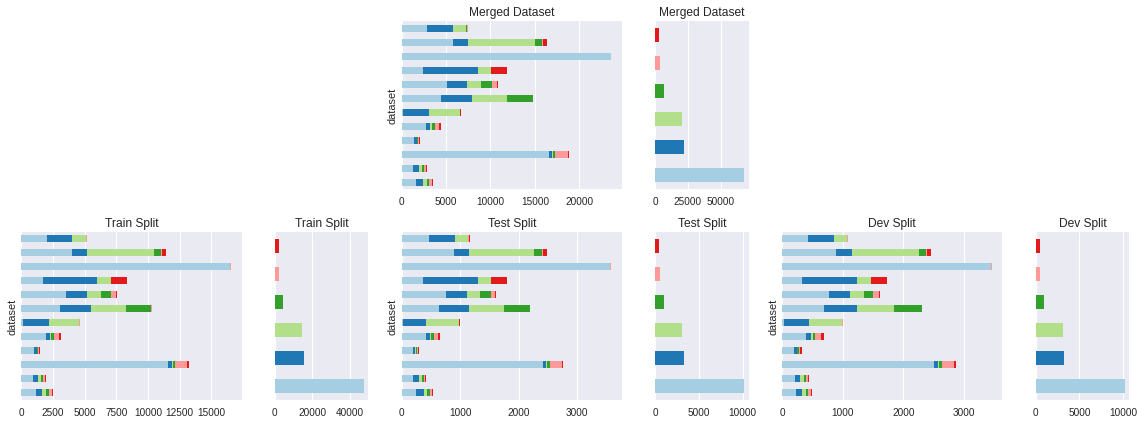

In [26]:
#@title ###Sanity Check (to make sure all splits have the same distributions)

fig = plt.figure(figsize=(16, 6), constrained_layout=True)

gs = GridSpec(2, 9, figure=fig)
ax1 = (fig.add_subplot(gs[0, 3:5]), fig.add_subplot(gs[0, 5:6]))

ax2 = (fig.add_subplot(gs[1, 0:2]), fig.add_subplot(gs[1, 2]))
ax3 = (fig.add_subplot(gs[1, 3:5]), fig.add_subplot(gs[1, 5]))
ax4 = (fig.add_subplot(gs[1, 6:-1]), fig.add_subplot(gs[1, -1]))

plot_df_distributions(final_df, "Merged Dataset", fig, ax1, False)
plot_df_distributions(train_df, "Train Split", fig, ax2, False)
plot_df_distributions(test_df, "Test Split", fig, ax3, False)
plot_df_distributions(dev_df, "Dev Split", fig, ax4, False)
plt.show()

# Ignore anything below here

In [ ]:

path = os.path.join(PROJECT_PATH, OUTPUT_PATH, 'for_salah')
os.makedirs(path, exist_ok=True)
os.chdir(path)

df = final_datasets['small'][0]


!ls

In [ ]:
seed_everything(SEED)
nlp = spacy.load('en_core_web_sm')

def splitter(dialogue):
    dialogue = remove_speaker_prefix(dialogue)

    turns = [t.strip() for t in dialogue.split("\n")]
    turns = [t for t in turns if t]

    idx1 = random.randrange(0, len(turns))

    tokens = nlp(turns[idx1])
    idx2 = random.randrange(0, len(tokens))

    prefix = turns[:idx1] + [tokens[:idx2].text]
    suffix = [tokens[idx2:].text] + turns[idx1+1:]

    return [turns, prefix, suffix]

split_names = ['train.csv', 'test.csv', 'dev.csv']
for split_df, split_name in zip(final_datasets['small'], split_names):
    print(f"processing '{split_name}'")
    df = pd.DataFrame(
        split_df['dialogue'].apply(splitter).to_list(), 
        columns=['text', 'input', 'output']
    )

    df.to_csv("_"+split_name)


In [ ]:
!ls

In [ ]:
a, b, c = df.iloc[0].to_list()

print('\n'.join(a))
print()
print()
print()
print('\n'.join(b))
print()
print()
print()
print('\n'.join(c))